In [153]:
%load_ext autoreload
%autoreload 2

import os
import subprocess
import sys
import warnings

warnings.simplefilter("ignore", FutureWarning)

import xclone_config
project_config = xclone_config
os.chdir(project_config.ROOT)

from collections import defaultdict, OrderedDict
import multiprocessing as mp
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns

from data_types import ase
import plotlib
import toolkit
import util
import test_phasing
from workspace.workspace_manager import WorkspaceManager

workspace = WorkspaceManager(
    task_name="preprocessing",
    experiment_info={"sample" : "STP_G&T", 
                     "modality" : "scDNA"},
    verbose=True
)
workspace.load_workspace()
print(workspace.experiment_info)
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'modality': 'scDNA', 'sample': 'STP_G&T'}


# Loading data

Requirements: 
- SNP counts (AD, DP)
- Phasing information
- Genomic segments for which it makes sense to aggregate SNPs

In [154]:
data = {
    data_type : util.pickle_load(workspace.tmp_data[data_type])
    for data_type in ["raw_snp_counts", "snp_counts", "phasing", "blocks"]
}
data["snp"] = data["snp_counts"]\
                [["CHROM", "POS"]]\
                .to_dense()\
                .astype(np.int64)

In [155]:
chrom_to_blocks = {
    str(chrom) : data["blocks"].query(f"CHROM == {chrom}")
    for chrom in data["blocks"]["CHROM"].unique()
}

In [6]:
%%time

# Here block coverage for each phased SNP is computed
# TODO: rewrite this using "bedtools intersect".
# This part doesn't scale well.

def blocks_that_overlap_snp(snp_tuple):
    chrom, pos = snp_tuple
    # 1-based to 0-based 
    pos -= 1 # because CellSNP is 1-based, but .bed files are 0-based
    blocks_on_chrom = chrom_to_blocks.get(str(chrom), None)
    if blocks_on_chrom is None:
        return ""
    mask = ((blocks_on_chrom.START <= pos) 
            & (pos < blocks_on_chrom.END))
    return '@'.join(blocks_on_chrom[mask].BLOCK_ID)

# result = [blocks_that_overlap_snp(snp_tuple) 
#           for snp_tuple in tqdm_notebook(data["snp"].values, 
#                                          "SNP processing")]
pool = mp.Pool(16)
result = pool.map(blocks_that_overlap_snp, 
                  tqdm_notebook(data["snp"].values, 
                                "SNP processing"))
pool.close()
pool.join()

CPU times: user 16.6 s, sys: 2.72 s, total: 19.4 s
Wall time: 3min 25s


In [7]:
""" Here the raw results computed in parallel are parsed """
snp_to_blocks, block_to_snps = {}, OrderedDict()

# This way we ensure proper block ordering
for block_id in data["blocks"].BLOCK_ID:
    block_to_snps[block_id] = []

for i, snp_tuple in tqdm_notebook(enumerate(data["snp"].values), 
                                  "mapping SNPs to blocks"):
    chrom, pos = snp_tuple
    snp = f"{chrom},{pos}"
    snp_to_blocks[snp] = result[i].split("@") if len(result[i]) > 0 else []
    for block in snp_to_blocks[snp]:
        block_to_snps[block].append(snp)

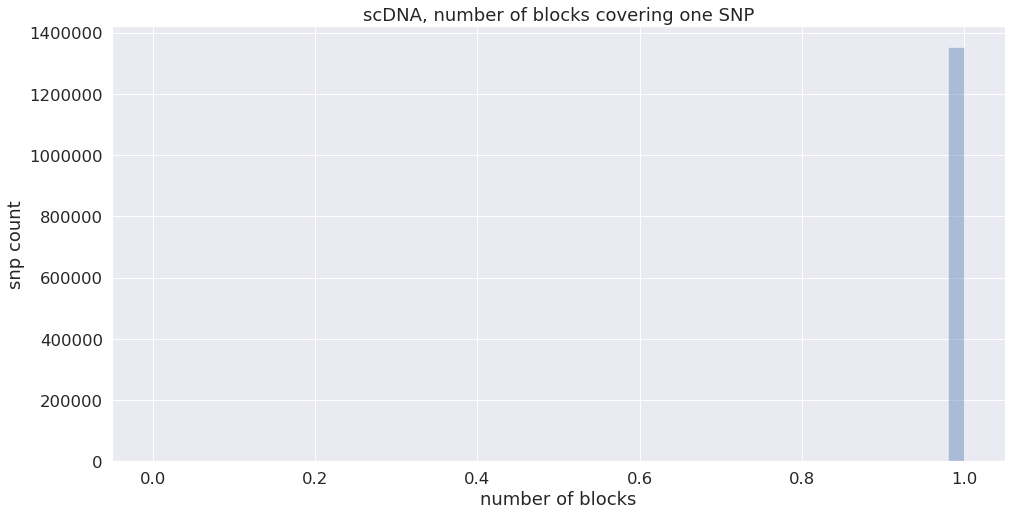

In [13]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.title(f"{workspace.experiment_info['modality']}, "
          "number of blocks covering one SNP")
plt.xlabel("number of blocks")
plt.ylabel("snp count")
sns.distplot([len(block_list) for block_list 
              in snp_to_blocks.values()], kde=False);

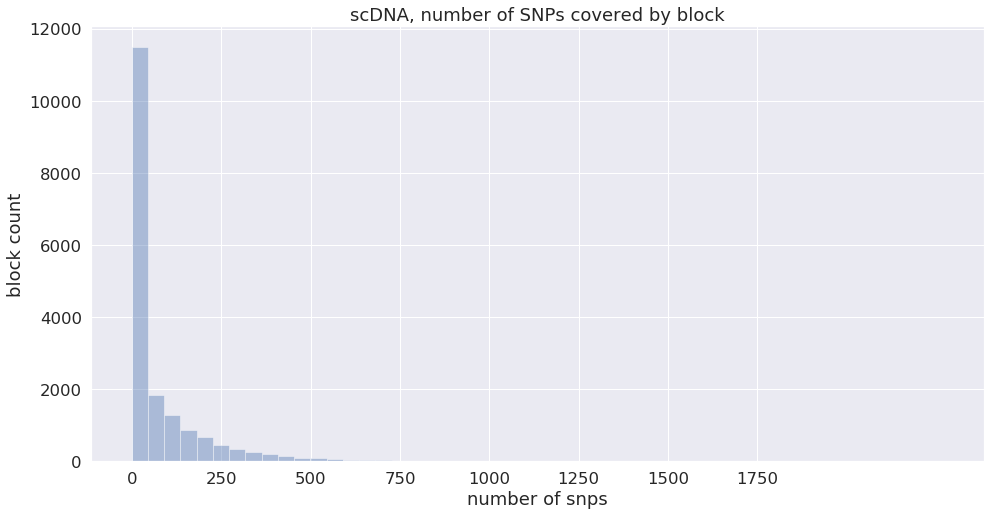

In [19]:
plt.figure(figsize=(16,8))
plt.title(f"{workspace.experiment_info['modality']}"
          ", number of SNPs covered by block")
plt.xlabel("number of snps")
plt.ylabel("block count")
sns.distplot([len(snp_list) for snp_list 
              in block_to_snps.values()], kde=False);
plt.xticks(np.arange(0, 2000, 250));

In [13]:
util.pickle_dump(
    snp_to_blocks, 
    f"{workspace.tmp_dir}/snp_to_blocks.pkl"
)
workspace.add_entry("snp_to_blocks", "snp_to_unity_cn.pkl")
util.pickle_dump(
    block_to_snps, 
    f"{workspace.tmp_dir}/block_to_snps.pkl"
)
workspace.add_entry("block_to_snps", "unity_cn_to_snps.pkl")

In [14]:
workspace.status()

Staged for commit: 
	-snp_to_blocks : snp_to_unity_cn.pkl
	-block_to_snps : unity_cn_to_snps.pkl


In [10]:
snp_to_idx = {snp : i for i, snp in 
              tqdm_notebook(enumerate(toolkit.extract_snps(data["snp_counts"])), 
                            "mapping snps to their index numbers "
                            "by position in the blocks")}

In [156]:
 chrom_to_blocks["3"].head()

,CHROM,START,END,BLOCK_ID
10414,3,65431,66175,10414
10415,3,95031,96029,10415
10416,3,577914,887698,10416
10417,3,898807,899774,10417
10418,3,1107266,1107559,10418


In [164]:
snps_in_3p_start = pd.DataFrame(
    [snp_tuple.split(",") for snp_tuple 
     in block_to_snps["10417"]],
    columns=["CHROM", "POS"]
).astype(int)
snps_in_3p_start_df = pd.merge(data["phasing"], 
                            snps_in_3p_start, 
                            on=["CHROM", "POS"])
least_nan_barcode = np.isnan(
    toolkit.extract_counts(data["snp_counts"])
).mean(axis=0).argmin().split("_")[0]
least_nan_count_df = pd.merge(
    data["snp_counts"][
        ["CHROM", "POS", "PHASE",
         f"{least_nan_barcode}_ad", 
         f"{least_nan_barcode}_dp"]
    ], 
    snps_in_3p_start_df
).to_dense()
ad_profile = np.array(toolkit.extract_counts(least_nan_count_df, "ad")).ravel()
dp_profile = np.array(toolkit.extract_counts(least_nan_count_df, "dp")).ravel()
# paternal_mask = (least_nan_count_df["PHASE"] == 1)
# old_ad_profile = ad_profile.copy()
# ad_profile[paternal_mask] = dp_profile[paternal_mask] - ad_profile[paternal_mask]
# np.sum(old_ad_profile[~np.isnan(old_ad_profile)] 
#        == ad_profile[~np.isnan(ad_profile)])

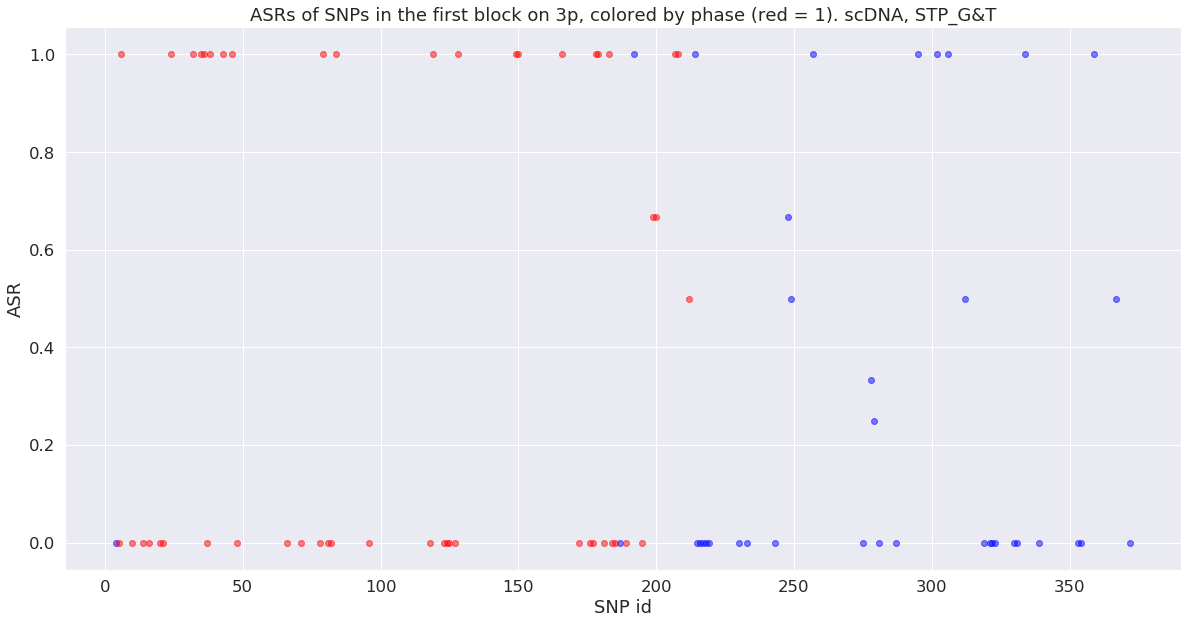

In [165]:
asr_profile = ad_profile / dp_profile
colors = ["blue", "red"]
sns.set(font_scale=1.5)
plt.figure(figsize=(20,10))
plt.xlabel("SNP id")
plt.ylabel("ASR")
plt.title(
    "ASRs of SNPs in the first block on 3p, colored by phase (red = 1). "
    f"{workspace.experiment_info['modality']}, "
    f"{workspace.experiment_info['sample']}"
)
for phase_val in [0, 1]:
    mask = (least_nan_count_df["PHASE"] == phase_val)
    same_phase_asr = asr_profile[mask]
    plt.scatter(
        x=np.arange(asr_profile.size)[mask],
        y=same_phase_asr, 
        alpha=0.5, 
        c=colors[phase_val],
    )


In [16]:
%%time

block_to_snp_ids = {block : np.array([snp_to_idx[snp] for snp in snp_list]) 
                   for block, snp_list 
                   in tqdm_notebook(block_to_snps.items(), 
                                    desc="mapping block to SNP ids"
                                    " (for faster row selection)")}

import numba
# @numba.jit(nopython=True)
def get_block_counts(ad, dp, snp_ids):
    if snp_ids.size > 0:
#         mask = np.zeros(ad.size).astype(np.bool)
#         mask[snp_ids] = True
#         ad_sample, dp_sample = ad[s], dp[mask]
        return np.nansum(ad[snp_ids]), np.nansum(dp[snp_ids])
    return np.nan, np.nan


def extract_block_counts(barcode):
    block_to_ad, block_to_dp = [], []
    # I need to convert these columns to dense format
    # because I need only a subset of rows on each iteration 
    ad = np.array(data["snp_counts"][f"{barcode}_ad"])
    dp = np.array(data["snp_counts"][f"{barcode}_dp"])
    
    # block_to_snps is an OrderedDict, so we can guarantee
    # that all the blocks are processed in a correct order
    for snp_ids in block_to_snp_ids.values():
        if len(snp_ids) > 0:
            dp_sum = np.nansum(dp[snp_ids])
            block_to_dp.append(np.nan if dp_sum == 0 else dp_sum)
            block_to_ad.append(np.nan if dp_sum == 0 
                               else np.nansum(ad[snp_ids]))
        else:
            block_to_ad.append(np.nan)
            block_to_dp.append(np.nan)
    
    return pd.SparseDataFrame({
        f"{barcode}_ad" : block_to_ad, 
        f"{barcode}_dp" : block_to_dp
    })


pool = mp.Pool(16)
result_list = pool.map(
    extract_block_counts, 
    tqdm_notebook(toolkit.extract_barcodes(data["snp_counts"]), 
                  desc="cell_barcode processing")
)
pool.close()
pool.join()
# result_list = [extract_block_counts(barcode) for barcode in 
#                tqdm_notebook(toolkit.extract_barcodes(data["snp_counts"]), 
#                              desc="cell_barcode processing")]
data["block_counts"] = pd.concat(result_list, axis=1)
data["block_counts"].info()


<class 'pandas.core.sparse.frame.SparseDataFrame'>
RangeIndex: 186 entries, 0 to 185
Columns: 14332 entries, AAACGAAAGGGAGATA-1_ad to TTTGTGTTCTTAATCC-1_dp
dtypes: Sparse[float64, nan](14332)
memory usage: 10.8 MB
CPU times: user 17.7 s, sys: 2.52 s, total: 20.2 s
Wall time: 38.9 s


In [152]:
data["block_counts"].insert(
    0, "BLOCK_ID", 
    list(block_to_snps.keys())
#     [block for block, snp_list 
#      in block_to_snps.items() 
#      if len(snp_list) > 0]
)
data["block_counts"].head()

KeyError: 'block_counts'

In [18]:
# data["clustering"] = util.pickle_load(f"{workspace.tmp_dir}/clustering.pkl")

In [19]:
# clean_barcodes = data["clustering"]["BARCODE"]
# raw_barcodes = toolkit.extract_barcodes(data["block_counts"])
# noisy_barcodes = np.setdiff1d(raw_barcodes, clean_barcodes)
# data["block_counts"].drop(
#     columns=[f"{barcode}_ad" for barcode in noisy_barcodes],
#     inplace=True
# )
# data["block_counts"].drop(
#     columns=[f"{barcode}_dp" for barcode in noisy_barcodes],
#     inplace=True
# )

In [20]:
# remaining_blocks = data["blocks"][
#     data["blocks"].BLOCK_ID.isin(data["block_counts"].BLOCK_ID)
# ].reset_index(drop=True)

# data["block_counts"] = data["block_counts"].merge(
#     remaining_blocks,
#     on="BLOCK_ID"
# )

In [21]:
# data["block_counts"] = data["block_counts"].to_sparse()

In [22]:
util.pickle_dump(
    data["block_counts"],
    os.path.join(
        workspace.tmp_dir,
        "block_counts.pkl"
    )
)
workspace.add_entry("block_counts", "stat_phased_unity_cn_counts.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/snp_to_blocks.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/snp_to_unity_cn.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_to_snps.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/unity_cn_to_snps.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/stat_phased_unity_cn_counts.pkl


In [37]:
import scipy.io as spio
import scipy.sparse as sparse
for count_type in ["ad", "dp"]:
    toolkit.extract_counts(
        data["block_counts"], 
        suffix=count_type
    ).to_csv(
        os.path.join(
            workspace.dir,
            f"stat_phased_unity_cn_{count_type}.csv"
        ), index=False
    )
#     spio.mmwrite(
#         os.path.join(
#             workspace.dir,
#             f"stat_phased_unity_cn_{count_type}.mtx"
#         ),
#         sparse.coo_matrix(
#             toolkit.extract_counts(
#                 data["block_counts"], 
#                 suffix=count_type
#             ).values
#         )
#     )

In [149]:
data["ase"] = ase.compute_ase(
    data["block_counts"], 
    toolkit.extract_barcodes(data["block_counts"])
).to_sparse()

KeyError: 'block_counts'

In [24]:
data["ase"].to_coo()

<186x7166 sparse matrix of type '<class 'numpy.float64'>'
	with 473599 stored elements in COOrdinate format>

In [25]:
import scipy.io 
scipy.io.mmwrite(f"{workspace.dir}/stat_phased_unity_cn_ase.mtx", 
                 data["ase"].to_coo())

In [26]:
util.pickle_dump(
    data["ase"],
    os.path.join(
        workspace.tmp_dir,
        "ase.pkl"
    )
)
workspace.add_entry("ase", "stat_phased_unity_cn_ase.pkl")
workspace.verify()
workspace.push()

/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/snp_to_blocks.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/snp_to_unity_cn.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_to_snps.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/unity_cn_to_snps.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/block_counts.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/stat_phased_unity_cn_counts.pkl
/icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/tmp/preprocessing/N5CC3E-T1/scATAC/ase.pkl —> /icgc/dkfzlsdf/analysis/B260/users/v390v/xclone/data/processed/N5CC3E-T1/scATAC/stat_phased_unity_cn_ase.pkl


In [148]:
data["ase"].to_csv(
    os.path.join(
        workspace.dir,
        "eagle2_stat_phased_cn_dp.csv"
    ), index=False
)

KeyError: 'ase'

In [29]:
data["blocks"][["BLOCK_ID", "CHROM", "START", "END"]].to_csv(
    os.path.join(
        workspace.dir,
        "unity_cn_annotation.csv"
    ), index=False
)
with open(os.path.join(workspace.dir, "barcodes.txt"), "w") as outfile:
    outfile.write("\n".join(toolkit.extract_barcodes(data["block_counts"])))